In [1]:
import pandas as pd
import calendar
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pymc3 as pm
import theano.tensor as tt
import arviz as az
from pymc3.distributions.dist_math import bound
import scipy.stats as ss

In [2]:
def le_dados_ana():
    lista_series_mensais=[]
    with open ('Clube_de_regatas.TXT','r') as file:
        for linha in file.readlines():
            if(linha.startswith("\n") or linha.startswith("/")):
                continue
            s=linha.replace(',','.').split(";")
            data_linha=datetime.strptime(s[2],'%d/%m/%Y')
            dias_no_mes=calendar.monthrange(data_linha.year,data_linha.month)
            rng=pd.date_range(data_linha,periods=dias_no_mes[1], freq='D')
            cons=[s[1] for i in range (dias_no_mes[1])]
            arrays=[rng,cons]
            tuples=list(zip(*arrays))
            index=pd.MultiIndex.from_tuples(tuples,names=['Data','Consistencia'])
            serie_linha=pd.Series(s[16:16+dias_no_mes[1]],index=index, name=s[0])
            lista_series_mensais.append(serie_linha)
    serie_completa=pd.concat(lista_series_mensais)
    serie_completa=pd.to_numeric(serie_completa, errors='coerce', downcast='float')
    serie_completa.sort_index(level=['Data','Consistencia'], inplace=True)
    definicao_de_duplicatas=serie_completa.reset_index(level=1, drop=True).index.duplicated(keep='last')
    dados_sem_duplicatas=serie_completa[~definicao_de_duplicatas]
    serie_com_index_unico=dados_sem_duplicatas.reset_index(level=1, drop=True)
    #serie_com_index_unico.to_json('test.json')
    return serie_com_index_unico

In [3]:
serie_de_dados=le_dados_ana()

In [4]:
serie_de_dados

Data
1941-01-01    142.442001
1941-01-02    267.057007
1941-01-03    307.851990
1941-01-04    326.447998
1941-01-05    195.709000
                 ...    
2014-11-26     42.068001
2014-11-27     52.375999
2014-11-28     79.758003
2014-11-29    121.233002
2014-11-30    141.126007
Name: 61834000, Length: 26997, dtype: float32

In [5]:
def calcula_ano_hidrologico(serie_com_index_unico):
    medias_mensais=serie_com_index_unico.groupby(pd.Grouper(freq='M')).mean()
    mes_menor_media=medias_mensais.groupby(pd.Grouper(freq='A')).idxmin()
    mes_menor_media=mes_menor_media.dt.month
    mes_comeca_ano_hidrologico=mes_menor_media.mode()
    return mes_comeca_ano_hidrologico

In [6]:
mes_comeca_ano_hidrologico=calcula_ano_hidrologico(serie_de_dados)

In [7]:
mes_comeca_ano_hidrologico

0    9
dtype: int64

In [8]:
def calcula_maximas_anuais(serie_com_index_unico):
    serie_maximas_anuais=serie_com_index_unico.groupby(pd.Grouper(freq='AS-SEP')).max()
    return serie_maximas_anuais[:-1] #Desconsidera o último valor (ano incompleto)

In [9]:
serie_maximas_anuais=calcula_maximas_anuais(serie_de_dados)

In [10]:
serie_maximas_anuais

Data
1940-09-01    372.480988
1941-09-01    559.979004
1942-09-01    591.476013
1943-09-01    394.835999
1944-09-01    568.922974
                 ...    
2009-09-01    786.273010
2010-09-01    658.395020
2011-09-01    406.454010
2012-09-01    577.911987
2013-09-01    248.539993
Freq: AS-SEP, Name: 61834000, Length: 74, dtype: float32

In [11]:
def linear_regression(max_data):
    max_data=max_data.reset_index()
    max_data['Data']=max_data['Data'].map(lambda x: x.year)
    slope, intercept, r_value, p_value, std_err = ss.linregress(max_data['Data'],max_data['61834000'])
    return slope, intercept, r_value, p_value, std_err

In [12]:
def plot_maximas(df, slope, intercept):
    #Plot série máximas
    df=df.reset_index()
    df['Data']=df['Data'].map(lambda x: x.year)
    plt.style.use('ggplot')
    grafico=df.plot(figsize=(15,9), style='--o', x='Data', y='61834000', color='blue', legend=False)
    grafico.set_xlabel('Tempo (anos)')
    grafico.set_ylabel('Vazão máxima (m³/s)')
    #Plot regressão
    index=(1940,2013)
    values=(516.66,753.51)
    regr=pd.Series(values, index=index)
    regr.plot(color='gray', ax=grafico)


In [13]:
# Calculates regression points to plot
index=(serie_maximas_anuais.index[0].year,serie_maximas_anuais.index[-1].year)
values=(serie_maximas_anuais[0],serie_maximas_anuais[-1])

#Plot

fig = go.Figure(data=go.Scatter(x=serie_maximas_anuais.index.map(lambda x: x.year),
                                y=serie_maximas_anuais,
                               mode='lines+markers'))

# fig.add_trace(go.Scatter(x=index, y=values,
#                     mode='lines'))

fig.update_layout(
    xaxis_title="Time (year)",
    yaxis_title="Discharge (m³/s)")
fig.show()

Text(0.5, 0, 'Time (year)')

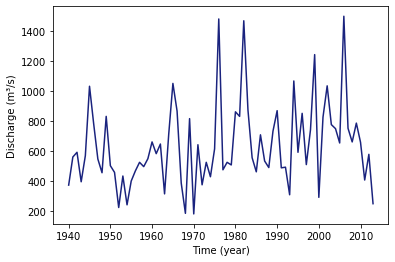

In [14]:
plt.plot(serie_maximas_anuais.index.map(lambda x: x.year), serie_maximas_anuais, color='#1A237E')
plt.ylabel('Discharge (m³/s)')
plt.xlabel('Time (year)')

In [1]:
def stationary_posterior(annual_max):
#     calibration_data=annual_max
    annual_max = pd.Series(annual_max.values, index=annual_max.index)
#     print('oi')
#     locm=annual_max.mean()
#     locs=annual_max.std()/(np.sqrt(len(annual_max)))
#     scalem=annual_max.std()
#     scales=annual_max.std()/(np.sqrt(2*(len(annual_max)-1)))
    with pm.Model() as model:
        # Priors for unknown model parameters
        c = pm.Beta('c', alpha=6, beta=9) #c=x-0.5: transformation in gev_logp is required due to Beta domain between 0 and 1
        loc = pm.Uniform('loc', lower=-10000, upper=10000)
        scale = pm.Uniform('scale', lower=0, upper=10000)
#         loc = pm.Normal('loc', mu=locm, sd=locs)
#         scale = pm.Normal('scale', mu=scalem, sd=scales)
        
        # Likelihood (sampling distribution) of observations | Since GEV is not implemented in pymc a custom log likelihood function was created
        def gev_logp(value):
            scaled = (value - loc) / scale
            logp = -(tt.log(scale)
                     + (((c-0.5) + 1) / (c-0.5) * tt.log1p((c-0.5) * scaled)
                     + (1 + (c-0.5) * scaled) ** (-1/(c-0.5))))
            bound1 = loc - scale/(c-0.5)
            bounds = tt.switch((c-0.5) > 0, value > bound1, value < bound1)
            return bound(logp, bounds, c != 0)
        gev = pm.DensityDist('gev', gev_logp, observed=annual_max)
#        step = pm.Metropolis()
        trace = pm.sample(2000, chains=2, cores=1, progressbar=True)
    return trace

NameError: name 'serie_maximas_anuais' is not defined

In [16]:
trace = stationary_posterior(serie_maximas_anuais)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [scale, loc, c]
Sampling chain 1, 1 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:02<00:00, 880.02it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.88606694675697, but should be close to 0.8. Try to increase the number of tuning steps.


C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anacon

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B1282AB908>,
      dtype=object)

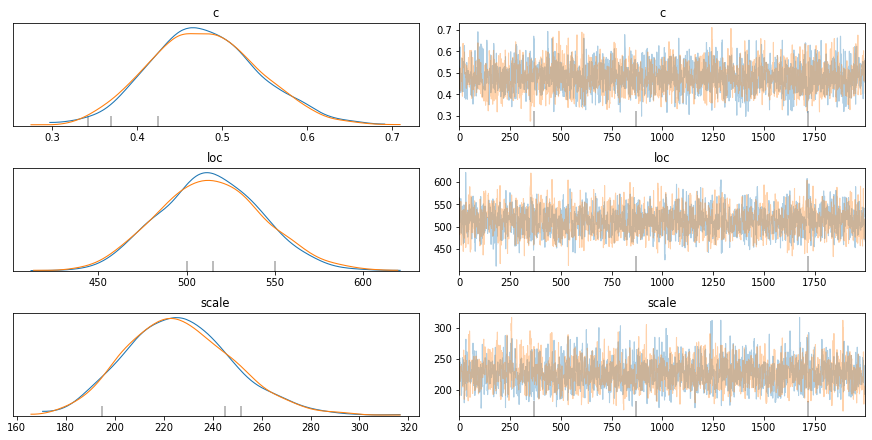

In [17]:
az.plot_trace(trace)

In [18]:
summary_gev0 = az.summary(trace)
summary_gev0

mean      sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
c        0.479   0.065    0.365    0.604      0.001    0.001    2572.0   
loc    513.356  28.863  461.282  568.160      0.591    0.420    2385.0   
scale  226.531  22.047  185.911  267.612      0.468    0.334    2221.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
c      2556.0    2575.0    2214.0    1.0  
loc    2362.0    2403.0    2365.0    1.0  
scale  2174.0    2269.0    2555.0    1.0

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B1260180C8>,
      dtype=object)

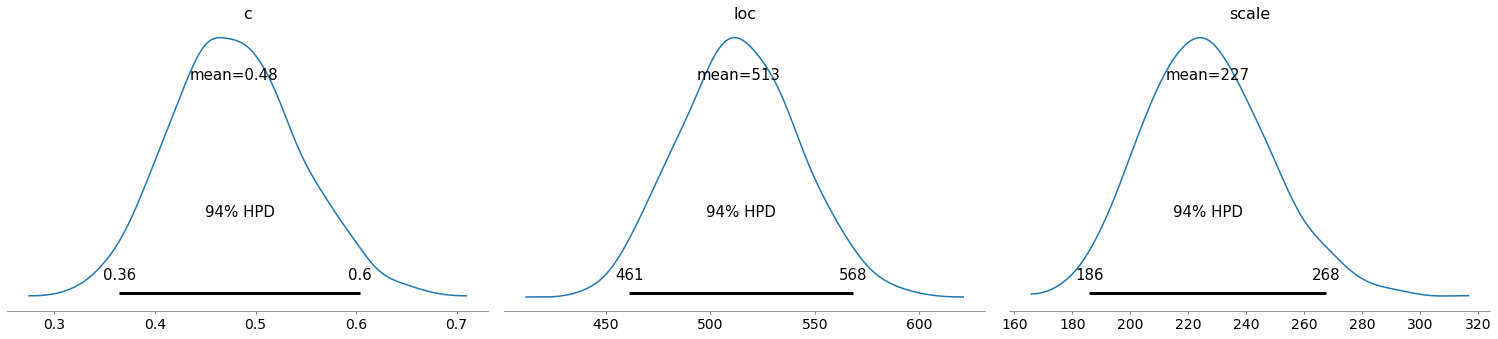

In [19]:
az.plot_posterior(trace)

In [20]:
pm.gelman_rubin(trace)

C:\Users\User\anaconda3\lib\site-packages\pymc3\stats\__init__.py:43: UserWarning:

gelman_rubin has been deprecated. In the future, use rhat instead.



<xarray.Dataset>
Dimensions:  ()
Data variables:
    c        float64 1.0
    loc      float64 1.001
    scale    float64 1.001

In [21]:
az.waic(trace)

Computed from 4000 by 74 log-likelihood matrix

        Estimate       SE
IC_waic  1034.96    14.30
p_waic      2.41        -

Text(0.5, 1.0, 'shape')

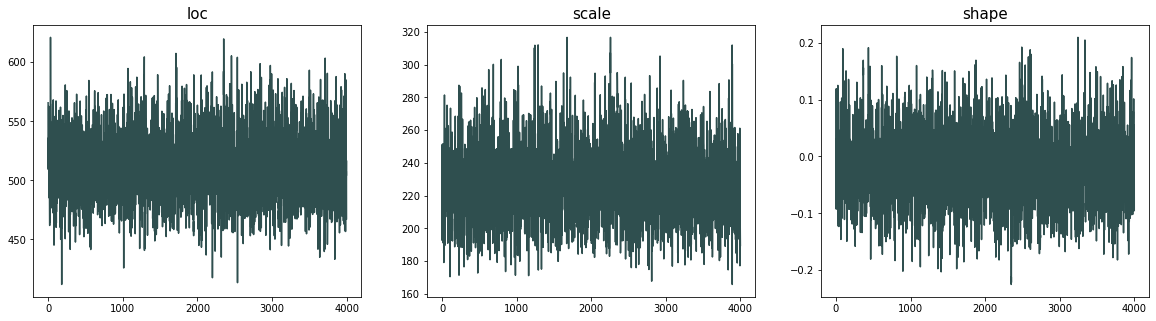

In [22]:
c_stationary = trace.get_values('c')
loc_stationary = trace.get_values('loc')
scale_stationary = trace.get_values('scale')

ax=[]
fig, ax = plt.subplots(1,3, figsize=(20, 5))
ano_resetado=list(range(len(serie_maximas_anuais)))
plt.rcParams.update({'font.size': 15})

ax[0].plot(range(len(loc_stationary)), loc_stationary, color='#2F4F4F')
ax[1].plot(range(len(scale_stationary)), scale_stationary, color='#2F4F4F')
ax[2].plot(range(len(c_stationary)), c_stationary-0.5, color='#2F4F4F')

ax[0].set_title("loc", fontsize=15)
ax[1].set_title("scale", fontsize=15)
ax[2].set_title("shape", fontsize=15)

In [23]:
t=range(len(serie_maximas_anuais))
def gev1(annual_max, covariant=[], alfa=0.95):
#     calibration_data=annual_max
#     serie_lista=list(calibration_data)
#     ano_resetado=pd.Series(range(len(annual_max)))

    #First regression (loc hiperparameters)

#     slope, intercept, r_value, pvalue_regress, std_err=ss.linregress(ano_resetado,calibration_data.values)
#     y_regress=ano_resetado.map(lambda x: x*slope+intercept)
#     e=calibration_data.reset_index(drop=True)-y_regress
#     se=(e**2).sum()/(len(calibration_data)-2)
#     xi_menos_xbarra=(calibration_data.map(lambda x: (x-calibration_data.mean())**2))
#     sb=np.sqrt(se/xi_menos_xbarra.sum())
#     sa=np.sqrt(se*(1/len(calibration_data)+calibration_data.mean()**2/xi_menos_xbarra.sum()))
#     cia=abs(slope+ss.t.ppf(1-alfa/2,len(calibration_data)-2)*sa)
#     cib=abs(intercept+ss.t.ppf(1-alfa/2,len(calibration_data)-2)*sb)
    
    #Scale hiperparameters
    
#     scalem=calibration_data.std()
#     scales=calibration_data.std()/(np.sqrt(2*(len(calibration_data)-1)))
    
    #Time covariant
    
    with pm.Model() as model:
        # Priors for unknown model parameters
#         m1 = pm.Normal('m1', mu=slope, sd=2*cia)
#         m2 = pm.Normal('m2', mu=intercept, sd=2*cib)
#         scale = pm.Normal('scale', mu=scalem, sd=scales)
        m1 = pm.Uniform('m1', lower=-100, upper=100)
        m2 = pm.Uniform('m2', lower=-1000, upper=1000)
        scale = pm.Uniform('scale', lower=0, upper=10000)
        c = pm.Beta('c', alpha=6, beta=9) #Remember, c=x-0.5: transformation in gev_logp is required due to Beta domain [0,1]

        # Likelihood (sampling distribution)
        def gev_logp(value, t):
            loc=m1*t+m2
            scaled = (value - loc) / scale
            logp = -(tt.log(scale)
                     + (((c-0.5) + 1) / (c-0.5) * tt.log1p((c-0.5) * scaled)
                     + (1 + (c-0.5) * scaled) ** (-1/(c-0.5))))
            bound1 = loc - scale/(c-0.5)
            bounds = tt.switch((c-0.5) > 0, value > bound1, value < bound1)
            return bound(logp, bounds, c != 0)
        gev = pm.DensityDist('gev', gev_logp, observed={'value': annual_max, 't': t})
        trace = pm.sample(2000, chains=1, cores=1, progressbar=True)
    return trace

In [24]:
trace_gev1 = gev1(serie_maximas_anuais, t)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [c, scale, m2, m1]
Sampling chain 0, 0 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:04<00:00, 501.08it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B12581DD88>,
      dtype=object)

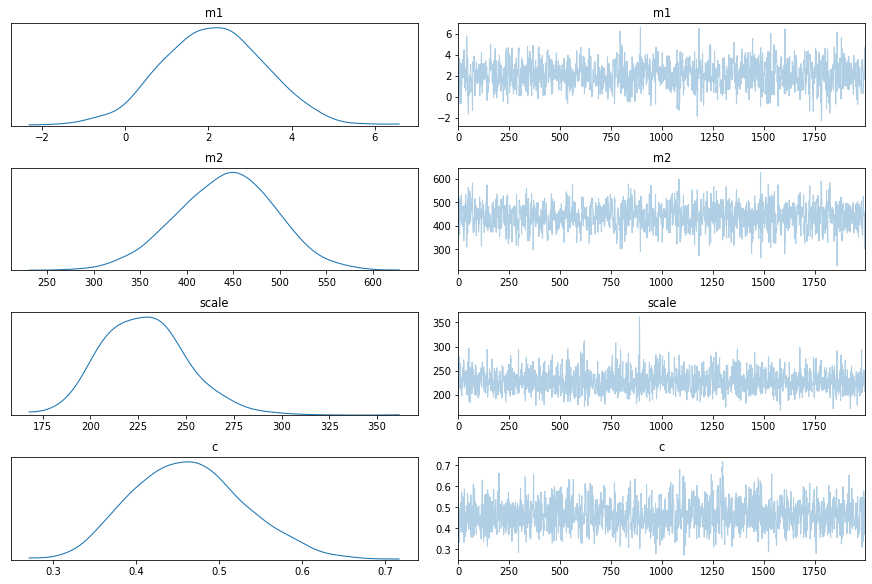

In [25]:
az.plot_trace(trace_gev1)

In [26]:
summary_gev1 = az.summary(trace_gev1)
summary_gev1

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean      sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
m1       2.109   1.240   -0.037    4.493      0.041    0.029     900.0   
m2     441.038  51.931  343.560  537.662      1.693    1.204     941.0   
scale  228.150  21.959  188.546  268.555      0.614    0.436    1279.0   
c        0.463   0.067    0.349    0.592      0.002    0.001    1191.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
m1      888.0     902.0     965.0    NaN  
m2      930.0     937.0    1108.0    NaN  
scale  1272.0    1280.0    1128.0    NaN  
c      1128.0    1217.0     983.0    NaN

Text(0.5, 1.0, 'shape')

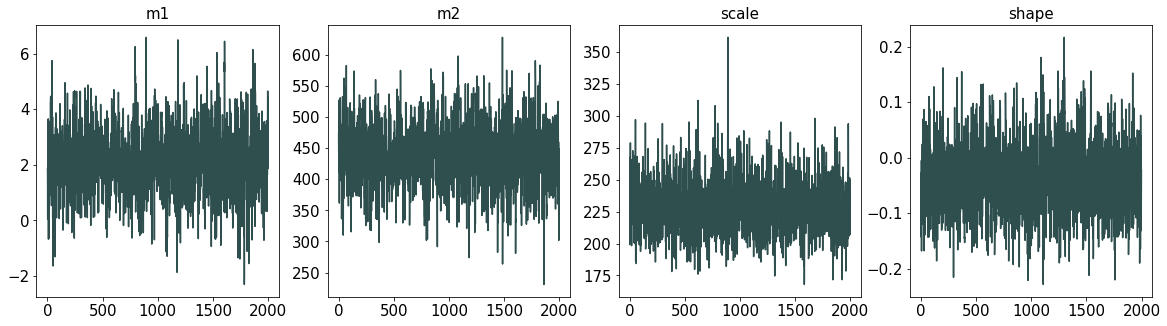

In [27]:
c_ns = trace_gev1.get_values('c')
m1_ns = trace_gev1.get_values('m1')
m2_ns = trace_gev1.get_values('m2')
scale_ns = trace_gev1.get_values('scale')

ax=[]
fig, ax = plt.subplots(1,4, figsize=(20, 5))
ano_resetado=list(range(len(serie_maximas_anuais)))
plt.rcParams.update({'font.size': 15})

ax[0].plot(range(len(m1_ns)), m1_ns, color='#2F4F4F')
ax[1].plot(range(len(m2_ns)), m2_ns, color='#2F4F4F')
ax[2].plot(range(len(scale_ns)), scale_ns, color='#2F4F4F')
ax[3].plot(range(len(c_ns)), c_ns-0.5, color='#2F4F4F')

ax[0].set_title("m1", fontsize=15)
ax[1].set_title("m2", fontsize=15)
ax[2].set_title("scale", fontsize=15)
ax[3].set_title("shape", fontsize=15)

# ax[1].set_xlabel('Time (years)', fontsize=12)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001B1260228C8>,
      dtype=object)

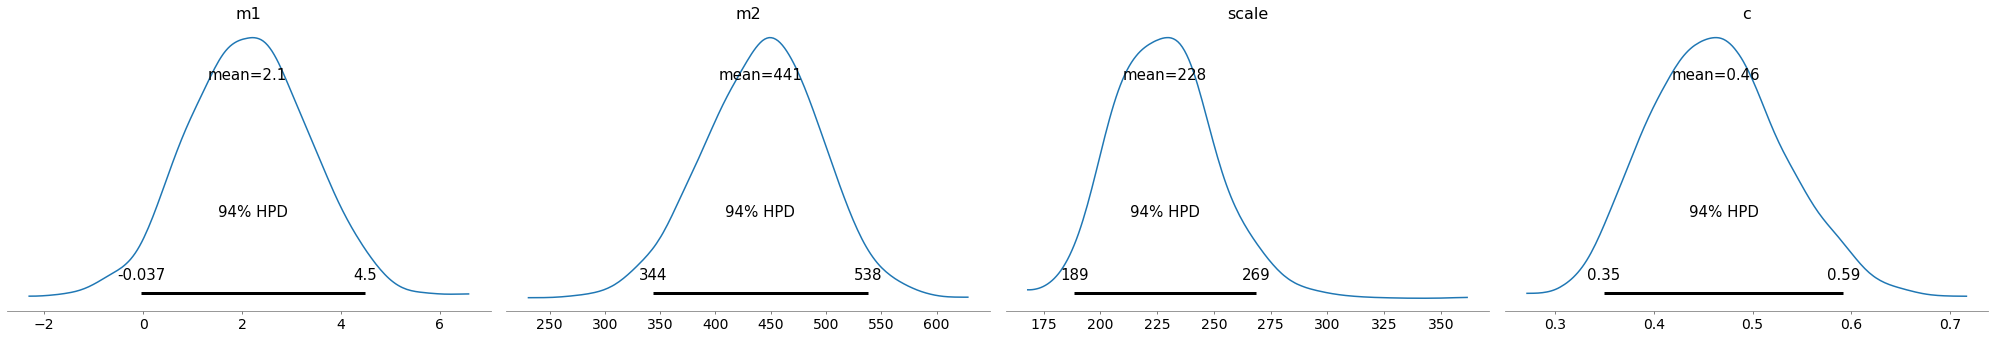

In [28]:
az.plot_posterior(trace_gev1)

In [29]:
pm.gelman_rubin(trace_gev1)

C:\Users\User\anaconda3\lib\site-packages\pymc3\stats\__init__.py:43: UserWarning:

gelman_rubin has been deprecated. In the future, use rhat instead.

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


<xarray.Dataset>
Dimensions:  ()
Data variables:
    m1       float64 nan
    m2       float64 nan
    scale    float64 nan
    c        float64 nan

In [30]:
az.waic(trace_gev1)

C:\Users\User\anaconda3\lib\site-packages\arviz\stats\stats.py:1196: UserWarning:

For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details



Computed from 2000 by 74 log-likelihood matrix

        Estimate       SE
IC_waic  1034.43    14.35
p_waic      3.39        -

There has been a warning during the calculation. Please check the results.

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:93: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



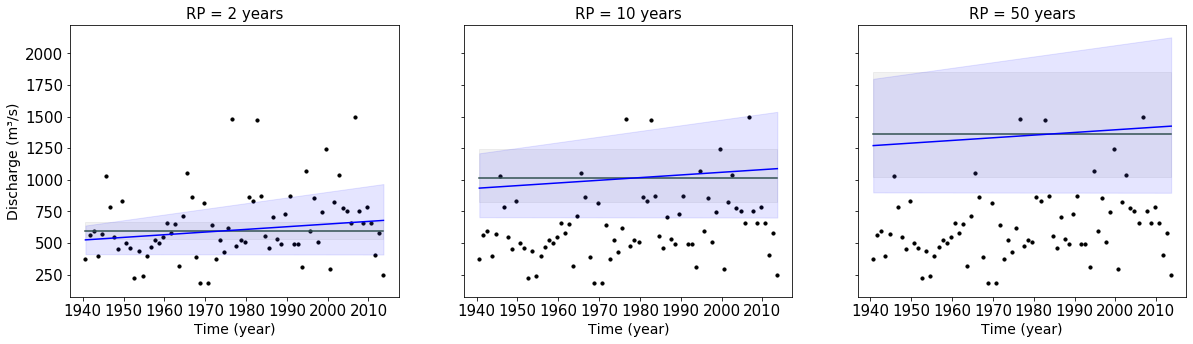

In [31]:
from plotly.subplots import make_subplots

#Plot GEV0

probability = [0.5, 0.9, 0.98]
rp = [2, 10, 50]
ax=[]
fig, ax = plt.subplots(1,3, figsize=(20, 5), sharey=True)
ano_resetado=list(range(len(serie_maximas_anuais)))
plt.rcParams.update({'font.size': 14})
# fig = make_subplots(rows=1, cols=3)

for i in range(0,len(probability)):
    #GEV0 plot
    
    q_gev0_mean = ss.genextreme.ppf(probability[i], -(summary_gev0.iloc[0]['mean']-0.5), summary_gev0.iloc[1]['mean'],summary_gev0.iloc[2]['mean'])
    q_gev0_low = ss.genextreme.ppf(probability[i], -(summary_gev0.iloc[0]['hpd_3%']-0.5), summary_gev0.iloc[1]['hpd_3%'],summary_gev0.iloc[2]['hpd_3%'])
    q_gev0_high = ss.genextreme.ppf(probability[i], -(summary_gev0.iloc[0]['hpd_97%']-0.5), summary_gev0.iloc[1]['hpd_97%'],summary_gev0.iloc[2]['hpd_97%'])

    quantiles_gev0_mean = [q_gev0_mean]*len(range(len(serie_maximas_anuais)))
    quantiles_gev0_low = [q_gev0_low]*len(range(len(serie_maximas_anuais)))
    quantiles_gev0_high = [q_gev0_high]*len(range(len(serie_maximas_anuais)))
    

    ax[i].scatter(serie_maximas_anuais.index,serie_maximas_anuais, color='black', s=10)
    ax[i].plot(serie_maximas_anuais.index, quantiles_gev0_mean, color='#2F4F4F')
    ax[i].fill_between(serie_maximas_anuais.index, quantiles_gev0_high, quantiles_gev0_low, color='grey', alpha=0.1)
    
    ax[i].set_title("RP = " + str(rp[i]) + " years", fontsize=15)
    ax[i].set_xlabel('Time (year)', fontsize=14)
    
    if i==0:
        ax[i].set_ylabel('Discharge (m³/s)', fontsize=14)

#     """GEV0 using Plotly"""
#     fig.add_trace(
#         go.Scatter(x=serie_maximas_anuais.index,
#                    y=serie_maximas_anuais,
#                    mode='markers',
#                    marker_color='grey'),
#         row=1, col=i+1
#     )
    
#     fig.add_trace(
#     go.Scatter(x=serie_maximas_anuais.index, y=quantiles_gev0_mean, marker_color='black'),
#     row=1, col=i+1)
    
        
#     fig.add_trace(go.Scatter(
#     x=serie_maximas_anuais.index,
#     y=quantiles_gev0_low),
#                  row=1, col=i+1)
    
#     fig.add_trace(go.Scatter(
#     x=serie_maximas_anuais.index,
#     y=quantiles_gev0_high, # fill area between trace0 and trace1
#     fill='tonexty',
#     fillcolor='rgba(26,150,65,0.3)'),
#                  row=1, col=i+1)
    
#     """End of GEV0 using Plotly"""
    
    #GEV1 plot
    
    q_gev1_mean=[]
    q_gev1_low=[]
    q_gev1_high=[]
    
    for t in ano_resetado:
        loc_gev1_mean = summary_gev1.iloc[0]['mean'] * t + summary_gev1.iloc[1]['mean']
        loc_gev1_low = summary_gev1.iloc[0]['hpd_3%'] * t + summary_gev1.iloc[1]['hpd_3%']
        loc_gev1_high = summary_gev1.iloc[0]['hpd_97%'] * t + summary_gev1.iloc[1]['hpd_97%']
               
        q_gev1_mean.append(ss.genextreme.ppf(probability[i], -(summary_gev1.iloc[3]['mean']-0.5), loc_gev1_mean, summary_gev1.iloc[2]['mean']))
        q_gev1_low.append(ss.genextreme.ppf(probability[i], -(summary_gev1.iloc[3]['hpd_3%']-0.5), loc_gev1_low, summary_gev1.iloc[2]['hpd_3%']))
        q_gev1_high.append(ss.genextreme.ppf(probability[i], -(summary_gev1.iloc[3]['hpd_97%']-0.5), loc_gev1_high, summary_gev1.iloc[2]['hpd_97%']))
    
    ax[i].plot(serie_maximas_anuais.index, q_gev1_mean, color='blue')
    ax[i].fill_between(serie_maximas_anuais.index, q_gev1_high, q_gev1_low, color='blue', alpha=0.1)
    
    
#     ax[i].plot(serie_maximas_anuais.index, q_gev1_mean, color='blue')
#     ax[i].fill_between(serie_maximas_anuais.index, q_gev1_high, q_gev1_low, color='blue', alpha=0.1)
    
    #Plot style
    
#     ax[i].set_ylim([0,2300])
#     ax[i].tick_params(axis='both',labelsize=10)
#     ax[i].set_title("RP = " + str(rp[i]) +" years",fontsize=12)
#     ax[0].set_ylabel('Discharge (m3/s)', fontsize=12) 
#     ax[i].set_xlabel('Time (years)', fontsize=12)

fig.show()

In [32]:
import hydrobr

prec = hydrobr.get_data.ANA.prec_data(['02147004'])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.77s/it]


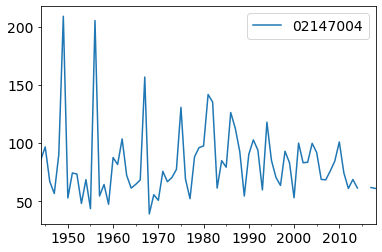

In [33]:
prec_max=calcula_maximas_anuais(prec)
prec_max.plot()

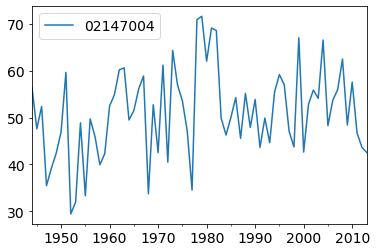

In [34]:
prec_99=prec.groupby(pd.Grouper(freq='AS-SEP')).quantile(0.99)
prec_99[:-6].plot()

In [35]:
import pymannkendall as mk
mk.original_test(serie_maximas_anuais[:-1])

Mann_Kendall_Test(trend='increasing', h=True, p=0.009182194285372924, z=2.6051951554011503, Tau=0.2085235920852359, s=548.0, var_s=44085.333333333336, slope=3.3222124756885174, intercept=458.31233817990085)

In [36]:
mk.original_test(prec_99[:-6])

Mann_Kendall_Test(trend='no trend', h=False, p=0.06953349001550979, z=1.8149376614441197, Tau=0.14865424430641822, s=359.0, var_s=38908.333333333336, slope=0.10000000000000009, intercept=47.328000000000046)

In [37]:
prec_acum=prec.groupby(pd.Grouper(freq='AS-SEP')).sum()

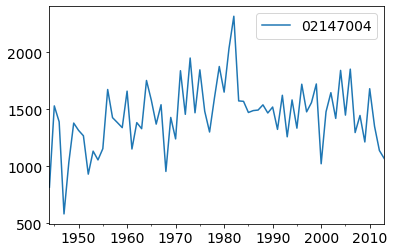

In [38]:
prec_acum[:-6].plot()

In [39]:
mk.original_test(prec_acum[:-6])

Mann_Kendall_Test(trend='increasing', h=True, p=0.03494649435005126, z=2.1089778412311557, Tau=0.17267080745341615, s=417.0, var_s=38908.333333333336, slope=3.6225806451613183, intercept=1337.7709677419343)

### Maximum Likelihood and Bootstrap estimates

In [40]:
cols = ['c', 'mu', 'scale']
df = pd.DataFrame(columns=cols, index=range(1000))
# df = pd.DataFrame([])
for i in range(1000):
    iterative_bootstrap_reshuffle = np.random.choice(serie_maximas_anuais, len(serie_maximas_anuais))
    c, loc, scale = ss.genextreme.fit(iterative_bootstrap_reshuffle)
    df.loc[i].c = c
    df.loc[i].mu = loc
    df.loc[i].scale = scale
#     parameters_list.append([c, loc, scale])
df


c       mu    scale
0    0.0591876  569.151  236.063
1    0.0458419  559.426  216.874
2     -4.85673  224.438  6.45196
3    0.0555351  487.819  200.211
4    0.0747519  521.551  215.355
..         ...      ...      ...
995   -3.94133  185.853  6.87078
996  0.0059664   541.71  223.749
997  0.0031586  463.452  213.431
998 -0.0922898   522.67   176.16
999   0.112676  500.838  239.367

[1000 rows x 3 columns]

In [41]:
(-df.c.quantile(0.5), df.mu.quantile(0.5), df.scale.quantile(0.5))

(0.010956513040080443, 505.657854482468, 211.77480418270096)

In [42]:
(-df.c.quantile(0.03), df.mu.quantile(0.03), df.scale.quantile(0.03))

(5.155061459310612, 181.9844214264683, 3.322819861553596)

In [43]:
(-df.c.quantile(0.97), df.mu.quantile(0.97), df.scale.quantile(0.97))

(-0.14733683236342754, 562.9581859672055, 267.24661138245347)

### precipitation 99th percentile covariant

In [44]:
prec_99[:-7]

02147004
1944-09-01    56.508
1945-09-01    47.632
1946-09-01    52.396
1947-09-01    35.490
1948-09-01    39.184
...              ...
2008-09-01    62.518
2009-09-01    48.440
2010-09-01    57.621
2011-09-01    46.732
2012-09-01    43.692

[69 rows x 1 columns]

In [45]:
def gev1P(annual_max, covariant):
      
    with pm.Model() as model:
        # Priors for unknown model parameters
#         m1 = pm.Normal('m1', mu=slope, sd=2*cia)
#         m2 = pm.Normal('m2', mu=intercept, sd=2*cib)
#         scale = pm.Normal('scale', mu=scalem, sd=scales)
        m1 = pm.Uniform('m1', lower=-100, upper=100)
        m2 = pm.Uniform('m2', lower=-10000, upper=10000)
        scale = pm.Uniform('scale', lower=0, upper=10000)
        c = pm.Beta('c', alpha=6, beta=9) #Remember, c=x-0.5: transformation in gev_logp is required due to Beta domain [0,1]

        # Likelihood (sampling distribution)
        def gev_logp(value, t):
            loc=m1*t+m2
            scaled = (value - loc) / scale
            logp = -(tt.log(scale)
                     + (((c-0.5) + 1) / (c-0.5) * tt.log1p((c-0.5) * scaled)
                     + (1 + (c-0.5) * scaled) ** (-1/(c-0.5))))
            bound1 = loc - scale/(c-0.5)
            bounds = tt.switch((c-0.5) > 0, value > bound1, value < bound1)
            return bound(logp, bounds, c != 0)
        gev = pm.DensityDist('gev', gev_logp, observed={'value': annual_max, 't': covariant})
        trace = pm.sample(2000, chains=1, cores=1, progressbar=True)
    return trace

In [46]:
trace_gevP99 = gev1P(serie_maximas_anuais[4:-1].to_list(),prec_99[:-7]['02147004'].to_list())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [c, scale, m2, m1]
Sampling chain 0, 0 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:08<00:00, 283.67it/s]
The acceptance probability does not match the target. It is 0.8920658789106582, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B12D42DE48>,
      dtype=object)

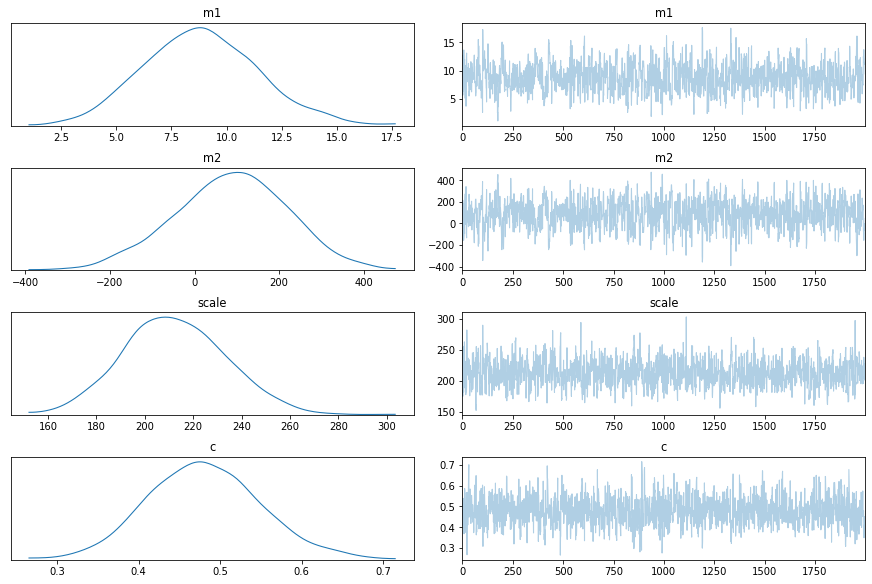

In [47]:
az.plot_trace(trace_gevP99)

In [48]:
az.waic(trace_gevP99)

Computed from 2000 by 69 log-likelihood matrix

        Estimate       SE
IC_waic   956.97    13.70
p_waic      3.23        -

In [49]:
trace_gevPacum = gev1P(serie_maximas_anuais[4:-1],prec_acum[:-7]['02147004'].to_list())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [c, scale, m2, m1]
Sampling chain 0, 0 divergences: 100%|████████████████████████████████████████████| 2500/2500 [00:12<00:00, 194.52it/s]
The acceptance probability does not match the target. It is 0.9027037097559067, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [50]:
summary_gevP99 = az.summary(trace_gevP99)
summary_gevP99

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean       sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
m1       8.815    2.573    3.769   13.527      0.100    0.072     668.0   
m2      84.048  132.905 -174.502  325.503      5.043    3.567     695.0   
scale  212.291   21.282  174.827  253.614      0.675    0.478     993.0   
c        0.480    0.069    0.352    0.615      0.002    0.002     995.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
m1      645.0     672.0     793.0    NaN  
m2      695.0     698.0     765.0    NaN  
scale   993.0     985.0     934.0    NaN  
c       995.0     996.0     905.0    NaN

In [51]:
az.waic(trace_gevP99)

Computed from 2000 by 69 log-likelihood matrix

        Estimate       SE
IC_waic   956.97    13.70
p_waic      3.23        -

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used

C:\Users\User\anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning:

Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001B12E54BEC8>,
      dtype=object)

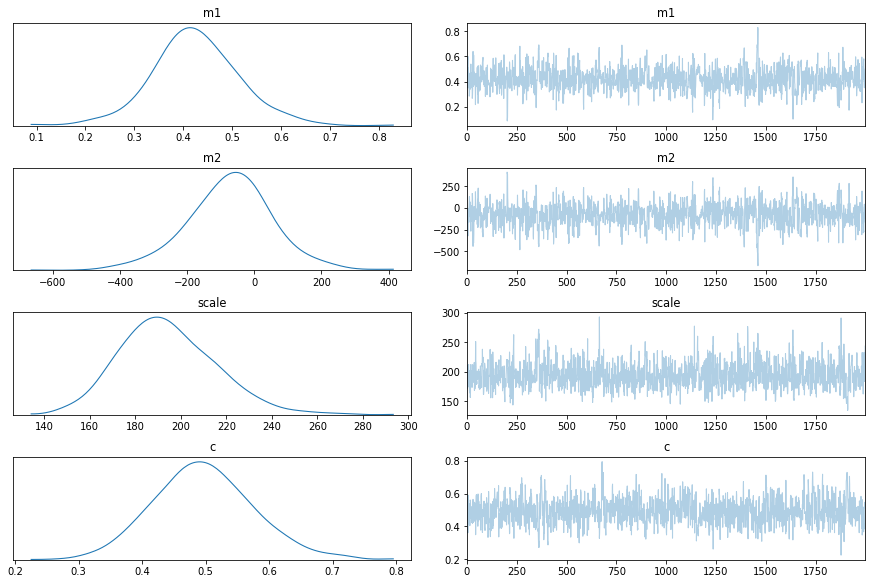

In [52]:
az.plot_trace(trace_gevPacum)

In [53]:
az.waic(trace_gevPacum)

Computed from 2000 by 69 log-likelihood matrix

        Estimate       SE
IC_waic   946.80    12.71
p_waic      3.30        -

In [56]:
summary_gevPAcum = az.summary(trace_gevPacum)
summary_gevPAcum

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


mean       sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
m1       0.424    0.088    0.269    0.610      0.003    0.002     742.0   
m2     -74.982  127.689 -336.631  159.831      4.570    3.753     781.0   
scale  194.258   21.425  156.901  235.526      0.812    0.580     696.0   
c        0.496    0.078    0.348    0.641      0.003    0.002     744.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
m1      695.0     765.0     732.0    NaN  
m2      579.0     804.0     770.0    NaN  
scale   682.0     720.0     738.0    NaN  
c       707.0     770.0     682.0    NaN

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



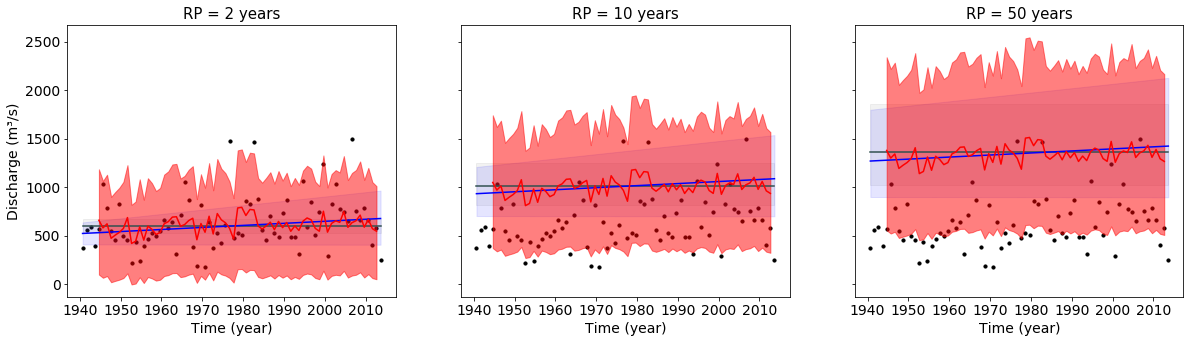

In [54]:
from plotly.subplots import make_subplots

#Plot GEV0

probability = [0.5, 0.9, 0.98]
rp = [2, 10, 50]
ax=[]
fig, ax = plt.subplots(1,3, figsize=(20, 5), sharey=True)
ano_resetado=list(range(len(serie_maximas_anuais)))
plt.rcParams.update({'font.size': 14})
# fig = make_subplots(rows=2, cols=3)

for i in range(0,len(probability)):
    #GEV0 plot
    
    q_gev0_mean = ss.genextreme.ppf(probability[i], -(summary_gev0.iloc[0]['mean']-0.5), summary_gev0.iloc[1]['mean'],summary_gev0.iloc[2]['mean'])
    q_gev0_low = ss.genextreme.ppf(probability[i], -(summary_gev0.iloc[0]['hpd_3%']-0.5), summary_gev0.iloc[1]['hpd_3%'],summary_gev0.iloc[2]['hpd_3%'])
    q_gev0_high = ss.genextreme.ppf(probability[i], -(summary_gev0.iloc[0]['hpd_97%']-0.5), summary_gev0.iloc[1]['hpd_97%'],summary_gev0.iloc[2]['hpd_97%'])

    quantiles_gev0_mean = [q_gev0_mean]*len(range(len(serie_maximas_anuais)))
    quantiles_gev0_low = [q_gev0_low]*len(range(len(serie_maximas_anuais)))
    quantiles_gev0_high = [q_gev0_high]*len(range(len(serie_maximas_anuais)))
    

    ax[i].scatter(serie_maximas_anuais.index,serie_maximas_anuais, color='black', s=10)
    ax[i].plot(serie_maximas_anuais.index, quantiles_gev0_mean, color='#2F4F4F')
    ax[i].fill_between(serie_maximas_anuais.index, quantiles_gev0_high, quantiles_gev0_low, color='grey', alpha=0.1)
    
    ax[i].set_title("RP = " + str(rp[i]) + " years", fontsize=15)
    ax[i].set_xlabel('Time (year)', fontsize=14)
    
    if i==0:
        ax[i].set_ylabel('Discharge (m³/s)', fontsize=14)
  
    #GEV1 plot
    
    q_gev1_mean=[]
    q_gev1_low=[]
    q_gev1_high=[]
    
    for t in ano_resetado:
        loc_gev1_mean = summary_gev1.iloc[0]['mean'] * t + summary_gev1.iloc[1]['mean']
        loc_gev1_low = summary_gev1.iloc[0]['hpd_3%'] * t + summary_gev1.iloc[1]['hpd_3%']
        loc_gev1_high = summary_gev1.iloc[0]['hpd_97%'] * t + summary_gev1.iloc[1]['hpd_97%']
               
        q_gev1_mean.append(ss.genextreme.ppf(probability[i], -(summary_gev1.iloc[3]['mean']-0.5), loc_gev1_mean, summary_gev1.iloc[2]['mean']))
        q_gev1_low.append(ss.genextreme.ppf(probability[i], -(summary_gev1.iloc[3]['hpd_3%']-0.5), loc_gev1_low, summary_gev1.iloc[2]['hpd_3%']))
        q_gev1_high.append(ss.genextreme.ppf(probability[i], -(summary_gev1.iloc[3]['hpd_97%']-0.5), loc_gev1_high, summary_gev1.iloc[2]['hpd_97%']))
    
    ax[i].plot(serie_maximas_anuais.index, q_gev1_mean, color='blue')
    ax[i].fill_between(serie_maximas_anuais.index, q_gev1_high, q_gev1_low, color='blue', alpha=0.1)
    
    
    #GEVPrec99 plot
    
    q_gev_prec99_mean=[]
    q_gev_prec99_low=[]
    q_gev_prec99_high=[]
    
    for prec in prec_99[:-7].values:
        loc_gev_prec99_mean = summary_gevP99.iloc[0]['mean'] * prec[0] + summary_gevP99.iloc[1]['mean']
        loc_gev_prec99_low = summary_gevP99.iloc[0]['hpd_3%'] * prec[0] + summary_gevP99.iloc[1]['hpd_3%']
        loc_gev_prec99_high = summary_gevP99.iloc[0]['hpd_97%'] * prec[0] + summary_gevP99.iloc[1]['hpd_97%']
        
        q_gev_prec99_mean.append(ss.genextreme.ppf(probability[i], -(summary_gevP99.iloc[3]['mean']-0.5), loc_gev_prec99_mean, summary_gevP99.iloc[2]['mean']))
        q_gev_prec99_low.append(ss.genextreme.ppf(probability[i], -(summary_gevP99.iloc[3]['hpd_3%']-0.5), loc_gev_prec99_low, summary_gevP99.iloc[2]['hpd_3%']))
        q_gev_prec99_high.append(ss.genextreme.ppf(probability[i], -(summary_gevP99.iloc[3]['hpd_97%']-0.5), loc_gev_prec99_high, summary_gevP99.iloc[2]['hpd_97%']))
        
    ax[i].plot(serie_maximas_anuais.index[4:-1], q_gev_prec99_mean, color='red')
    ax[i].fill_between(serie_maximas_anuais.index[4:-1], q_gev_prec99_high, q_gev_prec99_low, color='red', alpha=0.5)

fig.show()

In [55]:
serie_maximas_anuais.index[4:-1]

DatetimeIndex(['1944-09-01', '1945-09-01', '1946-09-01', '1947-09-01',
               '1948-09-01', '1949-09-01', '1950-09-01', '1951-09-01',
               '1952-09-01', '1953-09-01', '1954-09-01', '1955-09-01',
               '1956-09-01', '1957-09-01', '1958-09-01', '1959-09-01',
               '1960-09-01', '1961-09-01', '1962-09-01', '1963-09-01',
               '1964-09-01', '1965-09-01', '1966-09-01', '1967-09-01',
               '1968-09-01', '1969-09-01', '1970-09-01', '1971-09-01',
               '1972-09-01', '1973-09-01', '1974-09-01', '1975-09-01',
               '1976-09-01', '1977-09-01', '1978-09-01', '1979-09-01',
               '1980-09-01', '1981-09-01', '1982-09-01', '1983-09-01',
               '1984-09-01', '1985-09-01', '1986-09-01', '1987-09-01',
               '1988-09-01', '1989-09-01', '1990-09-01', '1991-09-01',
               '1992-09-01', '1993-09-01', '1994-09-01', '1995-09-01',
               '1996-09-01', '1997-09-01', '1998-09-01', '1999-09-01',
      

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:72: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



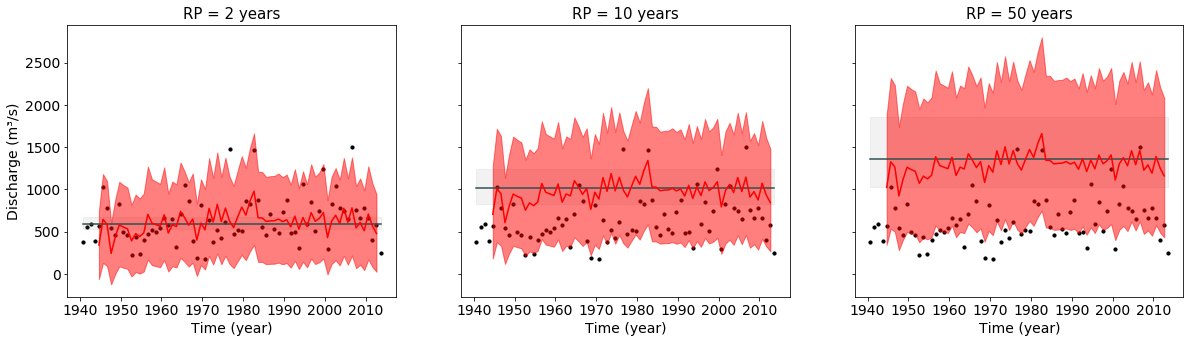

In [61]:
from plotly.subplots import make_subplots

#Plot GEV0

probability = [0.5, 0.9, 0.98]
rp = [2, 10, 50]
ax=[]
fig, ax = plt.subplots(1,3, figsize=(20, 5), sharey=True)
ano_resetado=list(range(len(serie_maximas_anuais)))
plt.rcParams.update({'font.size': 14})
# fig = make_subplots(rows=2, cols=3)

for i in range(0,len(probability)):
    #GEV0 plot
    
    q_gev0_mean = ss.genextreme.ppf(probability[i], -(summary_gev0.iloc[0]['mean']-0.5), summary_gev0.iloc[1]['mean'],summary_gev0.iloc[2]['mean'])
    q_gev0_low = ss.genextreme.ppf(probability[i], -(summary_gev0.iloc[0]['hpd_3%']-0.5), summary_gev0.iloc[1]['hpd_3%'],summary_gev0.iloc[2]['hpd_3%'])
    q_gev0_high = ss.genextreme.ppf(probability[i], -(summary_gev0.iloc[0]['hpd_97%']-0.5), summary_gev0.iloc[1]['hpd_97%'],summary_gev0.iloc[2]['hpd_97%'])

    quantiles_gev0_mean = [q_gev0_mean]*len(range(len(serie_maximas_anuais)))
    quantiles_gev0_low = [q_gev0_low]*len(range(len(serie_maximas_anuais)))
    quantiles_gev0_high = [q_gev0_high]*len(range(len(serie_maximas_anuais)))
    

    ax[i].scatter(serie_maximas_anuais.index,serie_maximas_anuais, color='black', s=10)
    ax[i].plot(serie_maximas_anuais.index, quantiles_gev0_mean, color='#2F4F4F')
    ax[i].fill_between(serie_maximas_anuais.index, quantiles_gev0_high, quantiles_gev0_low, color='grey', alpha=0.1)
    
    ax[i].set_title("RP = " + str(rp[i]) + " years", fontsize=15)
    ax[i].set_xlabel('Time (year)', fontsize=14)
    
    if i==0:
        ax[i].set_ylabel('Discharge (m³/s)', fontsize=14)
  
#     #GEV1 plot
    
#     q_gev1_mean=[]
#     q_gev1_low=[]
#     q_gev1_high=[]
    
#     for t in ano_resetado:
#         loc_gev1_mean = summary_gev1.iloc[0]['mean'] * t + summary_gev1.iloc[1]['mean']
#         loc_gev1_low = summary_gev1.iloc[0]['hpd_3%'] * t + summary_gev1.iloc[1]['hpd_3%']
#         loc_gev1_high = summary_gev1.iloc[0]['hpd_97%'] * t + summary_gev1.iloc[1]['hpd_97%']
               
#         q_gev1_mean.append(ss.genextreme.ppf(probability[i], -(summary_gev1.iloc[3]['mean']-0.5), loc_gev1_mean, summary_gev1.iloc[2]['mean']))
#         q_gev1_low.append(ss.genextreme.ppf(probability[i], -(summary_gev1.iloc[3]['hpd_3%']-0.5), loc_gev1_low, summary_gev1.iloc[2]['hpd_3%']))
#         q_gev1_high.append(ss.genextreme.ppf(probability[i], -(summary_gev1.iloc[3]['hpd_97%']-0.5), loc_gev1_high, summary_gev1.iloc[2]['hpd_97%']))
    
#     ax[i].plot(serie_maximas_anuais.index, q_gev1_mean, color='blue')
#     ax[i].fill_between(serie_maximas_anuais.index, q_gev1_high, q_gev1_low, color='blue', alpha=0.1)
    
    
    #GEVPrecAcum plot
    
    q_gev_precAcum_mean=[]
    q_gev_precAcum_low=[]
    q_gev_precAcum_high=[]
    
    for prec in prec_acum[:-7].values:
        loc_gev_precAcum_mean = summary_gevPAcum.iloc[0]['mean'] * prec[0] + summary_gevPAcum.iloc[1]['mean']
        loc_gev_precAcum_low = summary_gevPAcum.iloc[0]['hpd_3%'] * prec[0] + summary_gevPAcum.iloc[1]['hpd_3%']
        loc_gev_precAcum_high = summary_gevPAcum.iloc[0]['hpd_97%'] * prec[0] + summary_gevPAcum.iloc[1]['hpd_97%']
        
        q_gev_precAcum_mean.append(ss.genextreme.ppf(probability[i], -(summary_gevPAcum.iloc[3]['mean']-0.5), loc_gev_precAcum_mean, summary_gevPAcum.iloc[2]['mean']))
        q_gev_precAcum_low.append(ss.genextreme.ppf(probability[i], -(summary_gevPAcum.iloc[3]['hpd_3%']-0.5), loc_gev_precAcum_low, summary_gevPAcum.iloc[2]['hpd_3%']))
        q_gev_precAcum_high.append(ss.genextreme.ppf(probability[i], -(summary_gevPAcum.iloc[3]['hpd_97%']-0.5), loc_gev_precAcum_high, summary_gevPAcum.iloc[2]['hpd_97%']))
        
    ax[i].plot(serie_maximas_anuais.index[4:-1], q_gev_precAcum_mean, color='red')
    ax[i].fill_between(serie_maximas_anuais.index[4:-1], q_gev_precAcum_high, q_gev_precAcum_low, color='red', alpha=0.5)

fig.show()